# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [53]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [54]:
# Install requirements
!python -m pip install -r requirements.txt


## Imports

In [55]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [56]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))
])

# Create training set and define training dataloader
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create test set and define test dataloader
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


# Verify the form of the data
for images, labels in train_loader:
    print(f'Lot size images: {images.shape}')
    print(f'Lot size labels: {labels.shape}')
    break

Lot size images: torch.Size([64, 784])
Lot size labels: torch.Size([64])


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**DOUBLE CLICK THIS CELL TO MODIFY**

# My response to Justification of preprocessing steps.

Preprocessing is necessary to make the data suitable for input into a neural network, and here is the explanation of some points:

- **Normalizing images** (with a mean value of 0.5 and a standard deviation of 0.5) ensures that pixel values are in the interval [-1, 1], which helps stabilize and **accelerate** **training**.

 - **Resizing**: image flattening converts each image from a 2D matrix (28x28) to a 1D vector, which is necessary if a fully connected neural network is used as a model.

- **Data augmentation**: We added random rotation and random horizontal flipping to increase the diversity of the training data and improve the generalization of the model.

- **Tensor conversion**: We convert images to tensors using `transforms.ToTensor()`.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [57]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


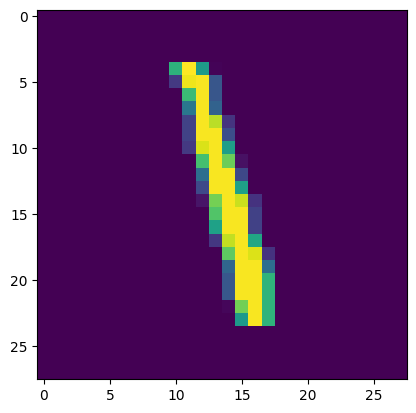

0


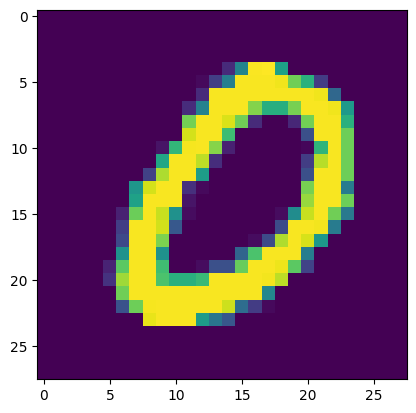

7


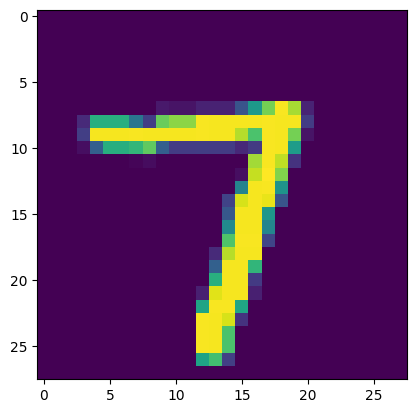

7


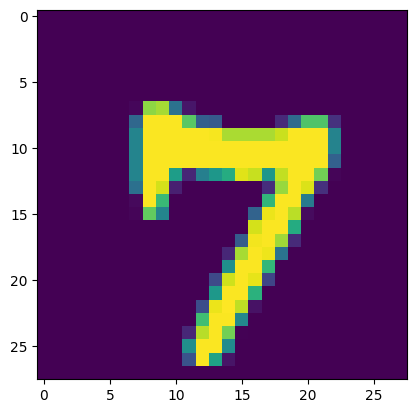

9


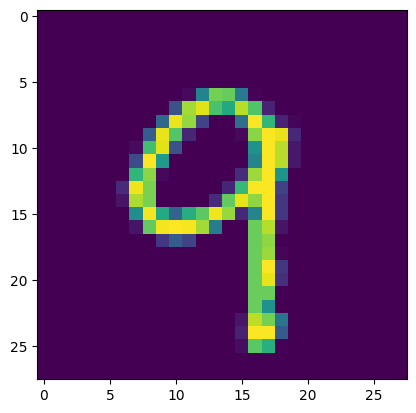

In [58]:
# Explore data
## YOUR CODE HERE ##

# Display the dataset using the show5 function
def unflatten_and_unnormalize(images):
    images = images.view(-1, 1, 28, 28)
    images = (images * 0.5) + 0.5
    return images

# Reverse transformations before moving to show5
for images, labels in train_loader:
    unflattened_images = unflatten_and_unnormalize(images)
    unflattened_labels = labels
    break

class CustomLoader:
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __iter__(self):
        yield self.images, self.labels

custom_loader = CustomLoader(unflattened_images, unflattened_labels)

# Display 5 images of the transformed dataset
show5(custom_loader)


In [59]:
## Explore data

# Create a second DataLoader without normalization and flattening
transform_no_norm = transforms.Compose([
    transforms.ToTensor()
])

# Download and load the MNIST dataset without additional transformations
train_dataset_no_norm = datasets.MNIST(root='./data', train=True, download=True, transform=transform_no_norm)
test_dataset_no_norm = datasets.MNIST(root='./data', train=False, download=True, transform=transform_no_norm)

# Create dataloaders to iterate over the untransformed datasets
train_loader_no_norm = DataLoader(dataset=train_dataset_no_norm, batch_size=64, shuffle=True)
test_loader_no_norm = DataLoader(dataset=test_dataset_no_norm, batch_size=64, shuffle=False)


# Explore the size and shape of data
for images, labels in train_loader_no_norm:
    print(f'Shape of the images (untransformed): {images.shape}')
    print(f'Label shape: {labels.shape}')
    break

for images, labels in train_loader:
    print(f'Shape of the images (untransformed): {images.shape}')
    print(f'Label shape: {labels.shape}')
    break


Shape of the images (untransformed): torch.Size([64, 1, 28, 28])
Label shape: torch.Size([64])
Shape of the images (untransformed): torch.Size([64, 784])
Label shape: torch.Size([64])


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [60]:
## YOUR CODE HERE ##
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create a network instance
model = Net()


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [61]:
## YOUR CODE HERE ##
## Specify a loss function and an optimizer, and instantiate the model.

# Loss function
loss_function = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# If you are using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [62]:
## YOUR CODE HERE ##

## Running your Neural Network
def train_model(num_epochs, learning_rate):
    # Define the loss function and the optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # List for storing the training loss in each period
    training_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Clean gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_function(outputs, labels)

            # Backward pass y optimización
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Print loss every 250 batches
            if (i + 1) % 250 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader)
        training_losses.append(epoch_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return training_losses

# Calling the training function
num_epochs = 5
learning_rate = 0.000005
training_losses = train_model(num_epochs, learning_rate)

Epoch [1/5], Step [250/938], Loss: 2.1419
Epoch [1/5], Step [500/938], Loss: 1.8984
Epoch [1/5], Step [750/938], Loss: 1.5294
Epoch [1/5], Loss: 1.9004
Epoch [2/5], Step [250/938], Loss: 1.1865
Epoch [2/5], Step [500/938], Loss: 1.0898
Epoch [2/5], Step [750/938], Loss: 0.9315
Epoch [2/5], Loss: 1.0724
Epoch [3/5], Step [250/938], Loss: 0.6242
Epoch [3/5], Step [500/938], Loss: 0.6566
Epoch [3/5], Step [750/938], Loss: 0.5819
Epoch [3/5], Loss: 0.7011
Epoch [4/5], Step [250/938], Loss: 0.6097
Epoch [4/5], Step [500/938], Loss: 0.4865
Epoch [4/5], Step [750/938], Loss: 0.4494
Epoch [4/5], Loss: 0.5505
Epoch [5/5], Step [250/938], Loss: 0.7756
Epoch [5/5], Step [500/938], Loss: 0.5441
Epoch [5/5], Step [750/938], Loss: 0.3872
Epoch [5/5], Loss: 0.4734


Plot the training loss (and validation loss/accuracy, if recorded).

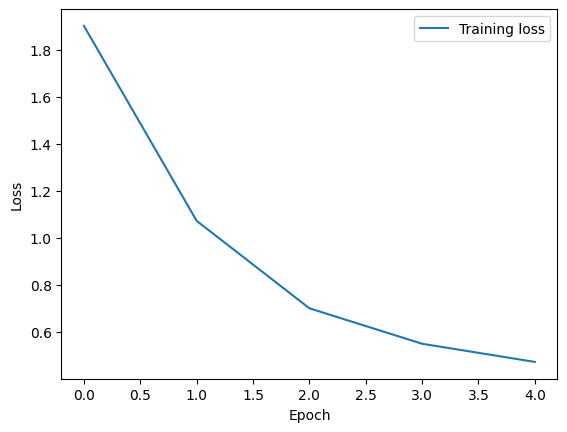

In [63]:
## YOUR CODE HERE ##

## Plot the training loss (and validation loss/accuracy, if recorded).
plt.plot(training_losses, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [64]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

    if accuracy >= 90:
        print('Great work! Your model has achieved at least 90% accuracy on the test set.')
    else:
        print('Your model accuracy is still under 90%. Keep experimenting with different hyperparameters and architectures.')

# Evaluate the model on the test set
evaluate_model(model, test_loader, device)

Accuracy of the model on the test set: 88.78%
Your model accuracy is still under 90%. Keep experimenting with different hyperparameters and architectures.


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

Epoch [1/20], Step [250/938], Loss: 0.4087
Epoch [1/20], Step [500/938], Loss: 0.3191
Epoch [1/20], Step [750/938], Loss: 0.2425
Epoch [1/20], Loss: 0.3030
Epoch [2/20], Step [250/938], Loss: 0.3543
Epoch [2/20], Step [500/938], Loss: 0.1973
Epoch [2/20], Step [750/938], Loss: 0.2831
Epoch [2/20], Loss: 0.1374
Epoch [3/20], Step [250/938], Loss: 0.1761
Epoch [3/20], Step [500/938], Loss: 0.1186
Epoch [3/20], Step [750/938], Loss: 0.0565
Epoch [3/20], Loss: 0.1011
Epoch [4/20], Step [250/938], Loss: 0.0629
Epoch [4/20], Step [500/938], Loss: 0.0174
Epoch [4/20], Step [750/938], Loss: 0.0641
Epoch [4/20], Loss: 0.0819
Epoch [5/20], Step [250/938], Loss: 0.0075
Epoch [5/20], Step [500/938], Loss: 0.1265
Epoch [5/20], Step [750/938], Loss: 0.3382
Epoch [5/20], Loss: 0.0718
Epoch [6/20], Step [250/938], Loss: 0.0423
Epoch [6/20], Step [500/938], Loss: 0.0048
Epoch [6/20], Step [750/938], Loss: 0.0095
Epoch [6/20], Loss: 0.0592
Epoch [7/20], Step [250/938], Loss: 0.0495
Epoch [7/20], Step [5

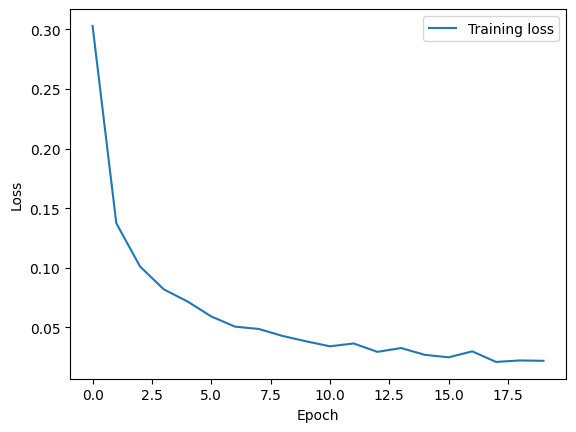

Accuracy of the model on the test set: 97.48%
Great work! Your model has achieved at least 90% accuracy on the test set.


In [65]:
## YOUR CODE HERE ##

## Improving your model

# Hyperparameter settings
learning_rate = 0.001
num_epochs = 20

# Call the training function with the new hyperparameters
model = Net().to(device)
training_losses = train_model(num_epochs, learning_rate)

# Graphing training loss
plt.plot(training_losses, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

evaluate_model(model, test_loader, device)

## Saving your model
Using `torch.save`, save your model for future loading.

In [66]:
## YOUR CODE HERE ##

def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f'Model saved to {path}')

model_path = 'mnist_model.pth'
save_model(model, model_path)


Model saved to mnist_model.pth
